# EDA empresa

# Análisis específico

Con base en el EDA preliminar, sabemos que las 2 tecnologías que más han crecido en los últimos años son "Cablemodem" y "Fibra óptica". Por ello, la empresa nos pide que enfoquemos el análisis en las mismas para decidir en cuál conviene invertir y en que zonas.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from funciones import eda_inicial
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

In [2]:
tecno_provincia = pd.read_excel("./Datasets/Acceso a Internet fijo por tecnología y provincia.xlsx",
                                  sheet_name="Tecnologia-provincia")

tecno_provincia.head()

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
0,2014,1,Buenos Aires,1567685,1000879,120960,16528,33824,2739876
1,2014,1,Capital Federal,445569,820161,17767,1866,14555,1299918
2,2014,1,Catamarca,24126,46,17,0,43,24232
3,2014,1,Chaco,52971,9497,30,0,58,62556
4,2014,1,Chubut,51066,539,866,10776,6974,70221


Del análisis preliminar, había surgido la presencia de numerosos outliers. Estos podían deberse a:
* Las diferencias en el número de accesos entre las provincias.
* Errores en la carga de datos.
* Inconsistencias entre los datos nacionales y provinciales, como menciona el mismo archivo para el año 2019.

Para acotar estas incertidumbres y trabajar con la información más actualizada, ceñiremos nuestro análisis al periodo 2019-2022 (12 trimestres).

In [3]:
tecno_provincia = tecno_provincia[tecno_provincia["Año"] > 2019]

Haremos un EDA inicial de este DataFrame filtrado.

In [4]:
eda_inicial(tecno_provincia)

<class 'pandas.core.frame.DataFrame'>
Index: 288 entries, 576 to 863
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Año           288 non-null    int64 
 1   Trimestre     288 non-null    int64 
 2   Provincia     288 non-null    object
 3   ADSL          288 non-null    int64 
 4   Cablemodem    288 non-null    int64 
 5   Fibra óptica  288 non-null    int64 
 6   Wireless      288 non-null    int64 
 7   Otros         288 non-null    int64 
 8   Total         288 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 22.5+ KB
None 

El número de duplicados en el DataFrame es: 0 

                Año  Trimestre     Provincia           ADSL    Cablemodem  \
count    288.000000  288.00000           288     288.000000  2.880000e+02   
unique          NaN        NaN            24            NaN           NaN   
top             NaN        NaN  Buenos Aires            NaN           NaN   
freq            NaN    

Con la información recabada hasta ahora de "tecno_provincia", podemos afirmar:
* El DataFrame tiene 288 filas y 9 columnas.
* No hay valores nulos ni duplicados.
* La información corresponde a 12 trimestres (2020 - 2022).
* Vemos que los mínimos para "Fibra óptica" y "Wireless" es 0 y para "Otros" es 29. Hagamos un análisis en busca de outliers.

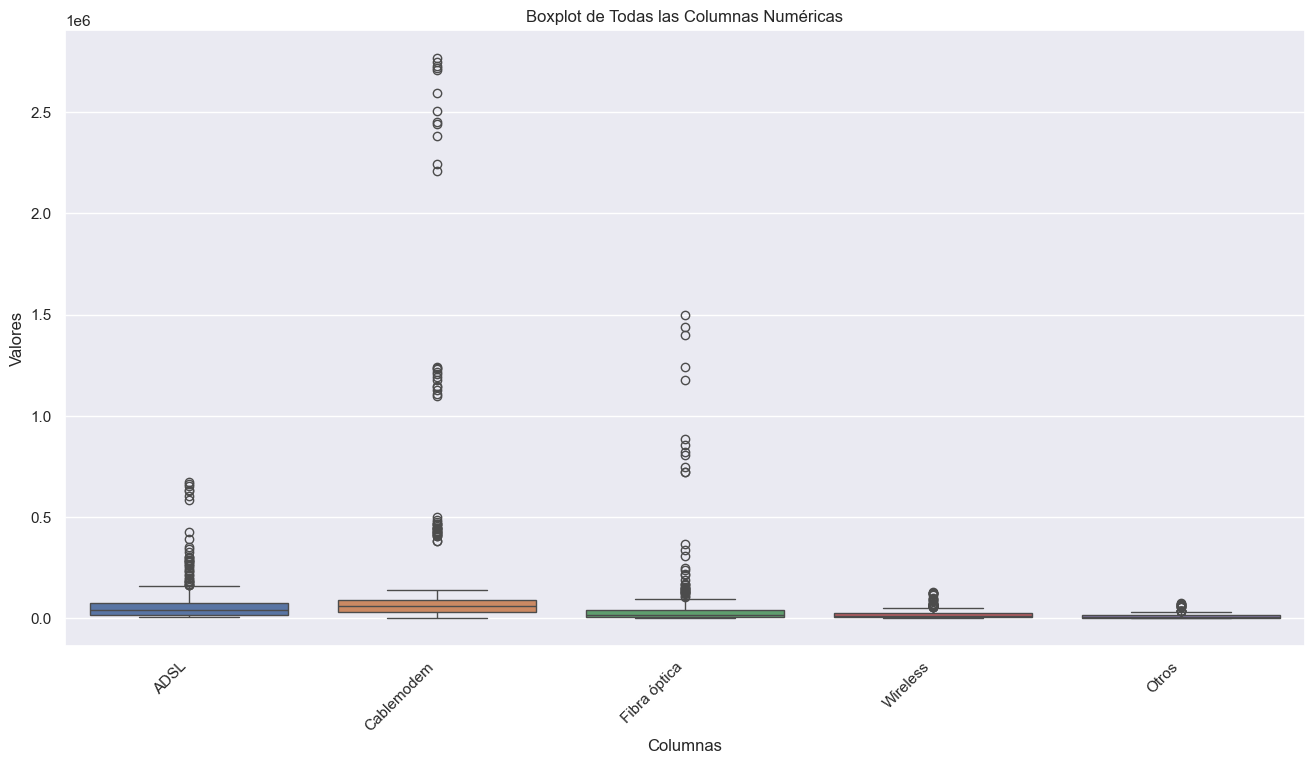

In [5]:
def get_outliers_df2(df, exclude = [], size = (16,8), ylim= None):

    # Configurar el tamaño de la figura
    plt.figure(figsize=size)

    # Crear el boxplot con todas las columnas numéricas
    sns.boxplot(data=df.drop(exclude, axis=1))

    # Personalizar el título y las etiquetas de los ejes
    plt.title("Boxplot de Todas las Columnas Numéricas")
    plt.xlabel("Columnas")
    plt.ylabel("Valores")

    # Rotar las etiquetas del eje x para mejorar la legibilidad
    plt.xticks(rotation=45, ha="right")

    # Ajusta los límites del eje y
    plt.ylim(ylim)

    # Mostrar el gráfico
    plt.show()

get_outliers_df2(tecno_provincia, exclude=["Año", "Trimestre", "Total"])

Los outliers superiores no nos llaman la atención porque se encuentran dentro de los mismos ordenes de magnitud que ya habíamos establecido. Además, los valores mas altos se dan para "Cablemodem" y "Fibra óptica" que son las tecnologías populares. Sumado a esto, tenemos la variabilidad interprovincias.

Volvamos a graficar, pero cambiando la escala del eje y para ver si hay outliers por debajo del bigote inferior.

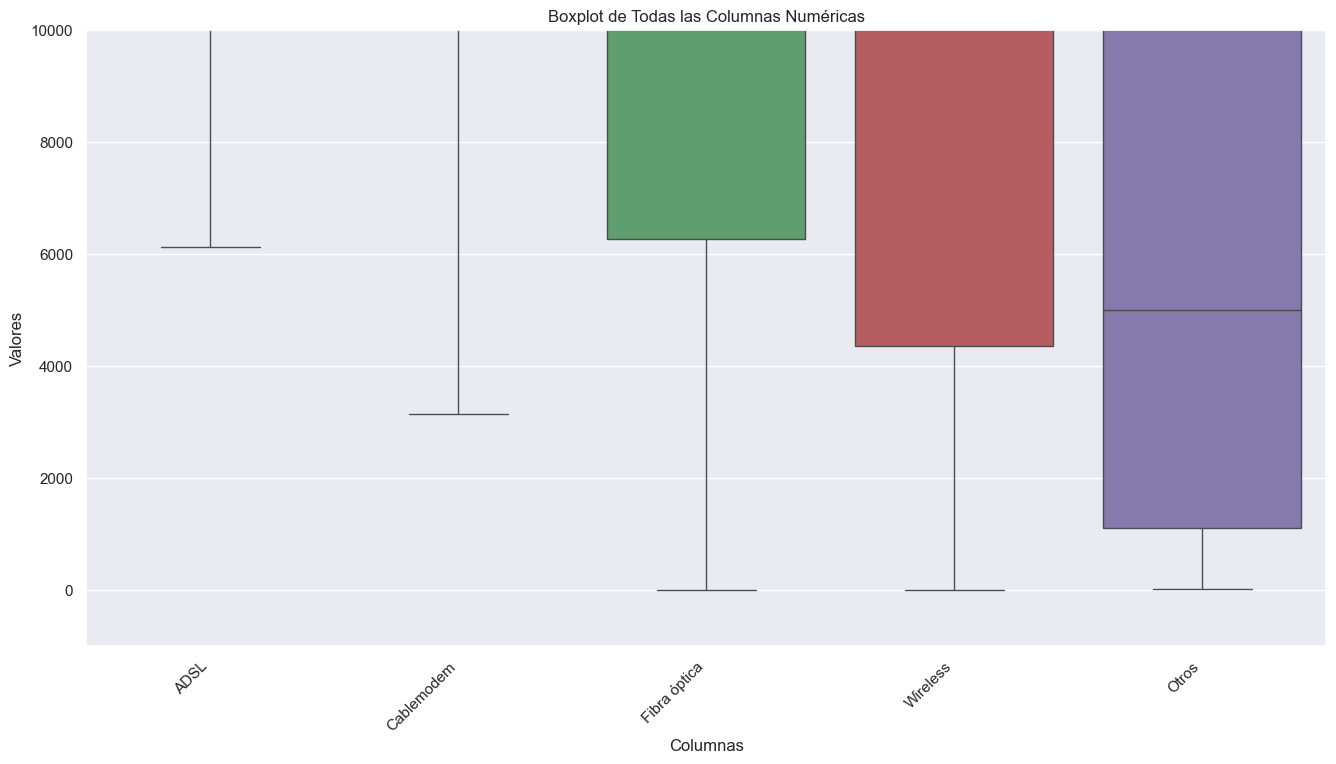

In [6]:
get_outliers_df2(tecno_provincia, exclude=["Año", "Trimestre", "Total"], ylim=(-1000,10000))

A pesar de haber visto valores muy bajos al llamar la función eda_inicial(), estos no representan valores atípicos. La diferencia con el EDA preliminar que se había hecho en el primer notebook, puede deberse a la poca fiabilidad de los datos del 2019, o que al rápido crecimiento de las tecnologías causara una gran dispersión en los datos.

Ahora, para concentrarnos solo en "Cablemodem" y "Fibra óptica", vamos a agrupar las otras 3 categorías en una.

In [7]:
tecno_provincia.head(1)

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
576,2020,1,Buenos Aires,673237,2210349,720688,85443,18334,3708051


In [8]:
tecno_provincia["Otras tecnologias"] = (tecno_provincia["ADSL"] 
                                        + tecno_provincia["Wireless"]
                                        + tecno_provincia["Otros"])

tecno_provincia.drop(columns=["ADSL", "Wireless", "Otros"], inplace=True)

tecno_provincia.head(3)

,Año,Trimestre,Provincia,Cablemodem,Fibra óptica,Total,Otras tecnologias
576,2020,1,Buenos Aires,2210349,720688,3708051,777014
577,2020,1,Capital Federal,1097635,38898,1353494,216961
578,2020,1,Catamarca,3146,12056,39635,24433


Para poder ver la evolución en el tiempo, crearemos la columna "Año-Trimestre".

In [9]:
# Concatenar las columnas "Año" y "Trimestre" en una nueva columna "Año-Trimestre".
tecno_provincia['Año-Trimestre'] = (
    tecno_provincia['Año'].astype(str) 
    + '-' + tecno_provincia['Trimestre'].astype(str))

# Visualizar el DataFrame con las modificaciones realizadas.
tecno_provincia.head(3)

,Año,Trimestre,Provincia,Cablemodem,Fibra óptica,Total,Otras tecnologias,Año-Trimestre
576,2020,1,Buenos Aires,2210349,720688,3708051,777014,2020-1
577,2020,1,Capital Federal,1097635,38898,1353494,216961,2020-1
578,2020,1,Catamarca,3146,12056,39635,24433,2020-1


Veamos que porcentaje del total ha ocupado cada tecnología y como eso ha ido variando.

In [10]:
tecno_por_anio_trim = tecno_provincia.groupby("Año-Trimestre")\
                                    [["Cablemodem", "Fibra óptica", "Otras tecnologias"]].sum()

tecno_por_anio_trim

,Cablemodem,Fibra óptica,Otras tecnologias
Año-Trimestre,,,
2020-1,4903674,1047817,2860935
2020-2,5005115,1106725,2919216
2020-3,5259351,1170879,2925969
2020-4,5371824,1311199,2888539
2021-1,5424782,1362976,2860214
2021-2,5641731,1472246,2749107
2021-3,5826257,1566048,2693236
2021-4,5984240,2072236,2433318
2022-1,6073426,2219533,2331050


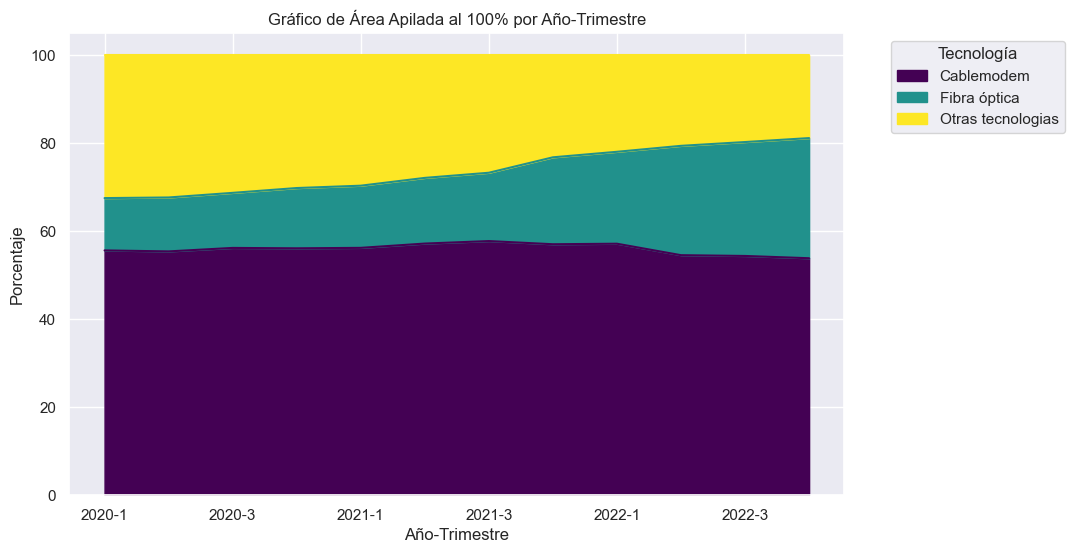

In [11]:
# Calcular el porcentaje de cada tecnología con respecto al total por trimestre
df_percentage = tecno_por_anio_trim.div(tecno_por_anio_trim.sum(axis=1), axis=0) * 100

# Crear un gráfico de área apilada al 100%
ax = df_percentage.plot(kind='area', stacked=True, colormap='viridis', figsize=(10, 6))

# Personalizar el gráfico
plt.title('Gráfico de Área Apilada al 100% por Año-Trimestre')
plt.xlabel('Año-Trimestre')
plt.ylabel('Porcentaje')
plt.legend(title='Tecnología', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar el gráfico
plt.show()

Vemos que "otras tecnologías" ocupan una porción cada vez menor del mercado. "Fibra óptica" está en franco crecimiento. Como observamos en el EDA preliminar, "Cablemodem" también sigue creciendo, pero al hacerlo a una velocidad menor, empieza a ocupar una porción menor del mercado. No obstante, esta porción representa más del 50%. 

En conclusión, "Cablemodem" domina el mercado pero "Fibra óptica" ha empezado a crecer a gran velocidad, por lo que considerar no solo el presente, sino la tendencia será fundamental a la hora de tomar decisiones de negocio.

Otra forma de evaluar las tendencias es usando "Google Trends", por lo que sumaremos otro dataset para aportar mas información.

In [12]:
trends = pd.read_csv("./Datasets/Google_trends.csv")

trends.head()

,Month,Cable modem,Optical fiber
0,2014-01,6,15
1,2014-02,6,20
2,2014-03,7,18
3,2014-04,6,19
4,2014-05,6,24


En este caso, se hizo la búsqueda para 2 tópicos: "Cable modem" y "Optical fiber". La ventaja de buscar por tópicos es que incluye palabras relacionadas o en otro idioma. 

La métrica obtenida se llama "Interés en el tiempo". Según Google "Los números representan el interés de búsqueda en relación con el punto más alto del gráfico para la región y el momento dados. Un valor de 100 es el pico de popularidad del término. Un valor de 50 significa que el término es la mitad de popular. Un valor de 0 significa que no hay datos suficientes para este término." 

La búsqueda se hizo para Argentina para el periodo 2014-2022. Analicemos los resultados.

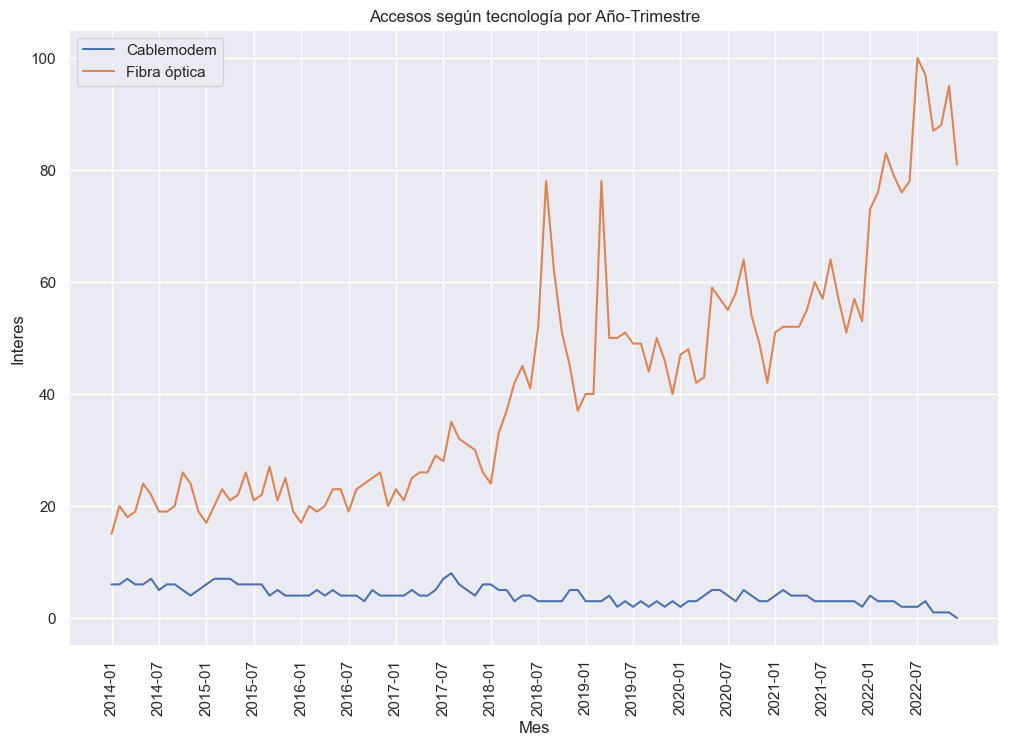

In [13]:
# Configurar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Crear el gráfico de líneas
sns.lineplot(x="Month", y="Cable modem", data=trends, label="Cablemodem")
sns.lineplot(x="Month", y="Optical fiber", data=trends, label="Fibra óptica")


# Personalizar el título y las etiquetas de los ejes
plt.title("Accesos según tecnología por Año-Trimestre")
plt.xlabel("Mes")
plt.ylabel("Interes")

# Girar etiquetas del eje x
plt.xticks(rotation=90)
plt.xticks(ticks=trends["Month"][::6])

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Vemos que al igual que la adopción, el interés por la Fibra óptica ha aumentado, mientras que aquel por el Cablemodem ha disminuido levemente. Todo parece apuntar a que la mejor estrategia es orientar la inversión hacia el desarrollo de Fibra óptica.

Habiendo establecido esto, nos enfocaremos en cuales son las zonas con mayor potencial de crecimiento. Ya sabemos la cantidad de accesos por Fibra óptica en cada provincia. Cruzaremos esta información con la población de cada provincia para evaluar la penetración en las mismas. Obtendremos esta información del [informe provisional](https://censo.gob.ar/wp-content/uploads/2023/02/cnphv2022_resultados_provisionales.pdf) emitido por INDEC en Enero de 2023, respecto al censo 2022.

In [14]:
poblacion = pd.read_excel("./Datasets/Provincia_poblacion.xlsx")

poblacion.head()

,Provincia,Población
0,Buenos Aires,17569053
1,Capital Federal,3120612
2,Catamarca,429556
3,Chaco,1142963
4,Chubut,603120


Ahora uniremos ambas tablas.

In [16]:
tecno_pcia = tecno_provincia.merge(poblacion, on="Provincia", how="inner")

tecno_pcia.head(3)

,Año,Trimestre,Provincia,Cablemodem,Fibra óptica,Total,Otras tecnologias,Año-Trimestre,Población
0,2020,1,Buenos Aires,2210349,720688,3708051,777014,2020-1,17569053
1,2020,2,Buenos Aires,2244277,723072,3777546,810197,2020-2,17569053
2,2020,3,Buenos Aires,2384557,749087,3937277,803633,2020-3,17569053


Calcularemos ahora los accesos por Fibra óptica cada 100 habitantes.

In [17]:
tecno_pcia["Accesos por cada 100 hab (Fibra óptica)"] = (
    (tecno_pcia["Fibra óptica"]/tecno_pcia["Población"])*100)

tecno_pcia.tail(3)

,Año,Trimestre,Provincia,Cablemodem,Fibra óptica,Total,Otras tecnologias,Año-Trimestre,Población,Accesos por cada 100 hab (Fibra óptica)
285,2022,2,Tucumán,15327,148823,254527,90377,2022-2,1703186,8.737918
286,2022,3,Tucumán,18518,162345,263117,82254,2022-3,1703186,9.531842
287,2022,4,Tucumán,20668,168717,263422,74037,2022-4,1703186,9.905964


Para poder ver situación actual de cada provincia y el potencial de crecimiento, graficaremos para el último trimestre de 2022, la población y los accesos cada 100 habitantes de la fibra óptica.

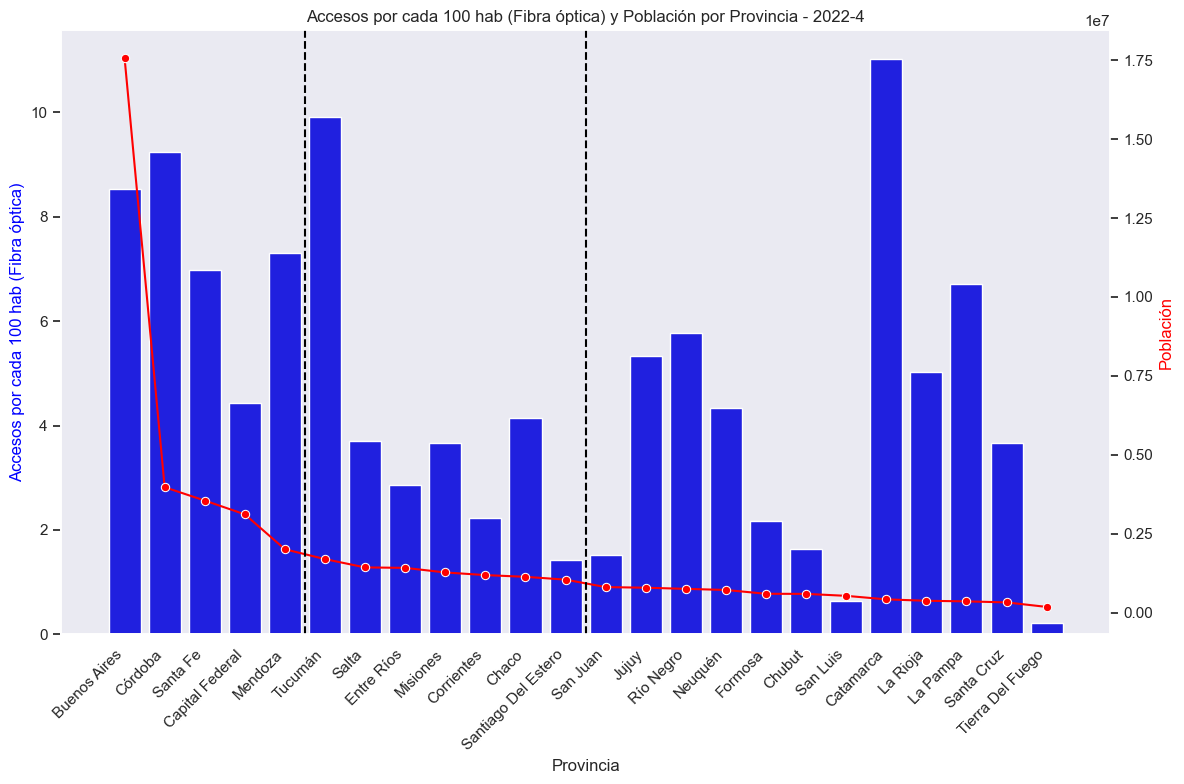

In [18]:
# Filtrar el DataFrame para obtener solo los datos del cuarto trimestre de 2022
tecno_pcia_subset = tecno_pcia[tecno_pcia["Año-Trimestre"] == "2022-4"]

# Ordenar el DataFrame por "Población" de mayor a menor
tecno_pcia_subset = tecno_pcia_subset.sort_values(by="Población", ascending=False)

# Crear una figura y ejes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Graficar barras en el eje izquierdo con el orden especificado
sns.barplot(x="Provincia", y="Accesos por cada 100 hab (Fibra óptica)", data=tecno_pcia_subset, ax=ax1, color="blue", order=tecno_pcia_subset["Provincia"])

# Crear un segundo eje y derecho
ax2 = ax1.twinx()

# Quitar la grilla horizontal
ax1.yaxis.grid(False)
ax2.yaxis.grid(False)

# Graficar línea en el eje derecho
sns.lineplot(x="Provincia", y="Población", data=tecno_pcia_subset, ax=ax2, color="red", marker="o", sort=False)

# Añadir una línea vertical entre "Mendoza" y "Tucumán"
linea_vertical_x = tecno_pcia_subset.index[tecno_pcia_subset["Provincia"] == "Tucumán"].tolist()[0] - 282.5  # Ajuste para centrar la línea
plt.axvline(x=linea_vertical_x, color='black', linestyle='--')

# Añadir una línea vertical entre "Santiago Del Estero" y "San Juan"
linea_vertical_x2 = tecno_pcia_subset.index[tecno_pcia_subset["Provincia"] == "San Juan"].tolist()[0] - 203.5  # Ajuste para centrar la línea
plt.axvline(x=linea_vertical_x2, color='black', linestyle='--')

# Rotar las etiquetas del eje x para una mejor legibilidad
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")

# Añadir etiquetas y título
ax1.set_xlabel("Provincia")
ax1.set_ylabel("Accesos por cada 100 hab (Fibra óptica)", color="blue")
ax2.set_ylabel("Población", color="red")
plt.title("Accesos por cada 100 hab (Fibra óptica) y Población por Provincia - 2022-4")

# Ajustar diseño para evitar solapamiento
fig.tight_layout()

# Mostrar el gráfico
plt.show()


En este gráfico las poblaciones están ordenadas por población decreciente. Podemos dividir el análisis en 3 secciones: 
* ___Sección 1:__ Desde Buenos Aires hasta Mendoza (poblaciones mayores a 2 millones).
* __Sección 2:__ Desde Tucumán hasta Santiago Del Estero (pobaciones entre 1 y 2 millones).
* __Sección 3:__ Desde San Juan hasta Tierra del Fuego (población menores a 1 millón.)

Las oportunidades de crecimiento se darán en aquellas provincias donde la penetración de la fibra óptica sea baja y la población sea alta, porque indica que todavía hay una gran parte del mercado para cautivar.

Para la primera sección, la provincia que mas se destaca es Capital Federal, por su alta población y baja penetración del servicio de fibra óptica. Sabemos además que es un polo de servicios a nivel nacional por lo que los requerimientos del servicio de internet a alta velocidad son altos.

En la segunda sección, donde todas las poblaciones son aproximadamente similares entre sí, se destacan Santiago del Estero y Corrientes como aquellas con menor pentración del servicio. Entre Rios, Misiones y Chaco también pueden representar buenas opciones, porque la penetración es baja, y limitan con corrientes, por lo que la extensión de la red de fibra óptica podría ser menos costosa.

En la tercera sección, donde el número de habitantes también es similar, Tierra del Fuego es aquella con menor penetración. Sin embargó, debe considerarse que aquí se está incorporando la porción de la Antártida Argentina e islas del Antártico Sur, por lo que la extensión y las distancias pueden causar que la logística sea demasiado costosa. Formosa, por su baja penetración de fibra óptica y cercanía geográfica (conforma el nordeste argentino (NEA) junto con Chaco, Corrientes y Misiones), sería una zona a privilegiar en el desarrollo de la red.

En resumen, considerando penetración del servicio de fibra óptica, población total y geografía, se sugiere priorizar la inversión en fibra óptica en las siguientes provincias:
* Capital Federal
* Santiago Del Estero
* Corrientes
* Entre Rios
* Misiones
* Chaco
* Formosa

Podemos visualizarlas a continuación.

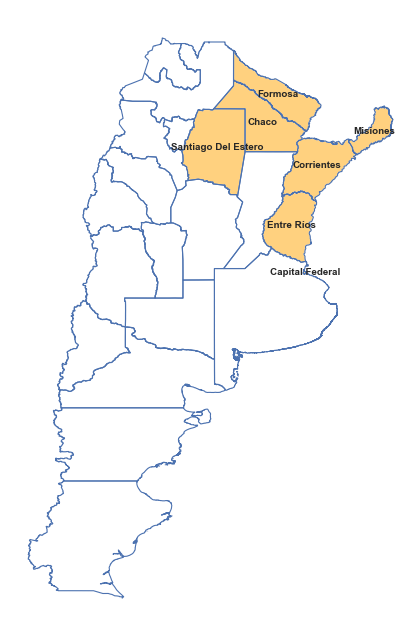

In [23]:
# Cargar el archivo JSON con las coordenadas
file_path = "./Datasets/Provincia_coordenadas.json"
gdf = gpd.read_file(file_path)

# Excluir la Antártida
gdf = gdf[gdf["nam"] != "Tierra del Fuego, Antártida e Islas del Atlántico Sur"]

# Lista de provincias que deseas resaltar
provincias_a_resaltar = ["Capital Federal", "Santiago Del Estero", "Corrientes", "Entre Ríos", "Misiones", "Chaco", "Formosa"]

# Crear una columna para identificar las provincias a resaltar
gdf["resaltar"] = gdf["nam"].isin(provincias_a_resaltar)

# Crear el mapa base
fig, ax = plt.subplots(figsize=(12, 8))
gdf.boundary.plot(ax=ax, linewidth=0.8)

# Resaltar las provincias específicas
gdf[gdf["resaltar"]].plot(ax=ax, color='orange', alpha=0.5)

# Añadir etiquetas de provincia solo para las provincias a resaltar con un tamaño menor y negrita
for x, y, label in zip(gdf[gdf["resaltar"]].geometry.centroid.x, gdf[gdf["resaltar"]].geometry.centroid.y, gdf[gdf["resaltar"]]["nam"]):
    ax.text(x, y, label, fontsize=7, ha='center', va='center', fontweight='bold')

# Configurar el aspecto del mapa
ax.set_aspect('equal')
plt.axis('off')

# Mostrar el mapa
plt.show()